# Lab 5. Transformers

---

How to Use This Notebook
---

**Recommended Setup**
- For the best experience, **run this notebook on [Google Colab](https://colab.research.google.com/)**—especially if your local machine is slow.  
- In Colab, **enable GPU support** by going to:  
  `Runtime > Change runtime type > Hardware accelerator > GPU`


**Homework Tasks**

 - Homework tasks are clearly marked throughout the notebook in the following format:

   > ---

   > <span style="color:red"><b>TASK X</b> - [<i>some text</i>]:</span>

   > ---

   > ```Your code ....```

   > ---

   > *End of Task X.* [*Instructions for passing*]

 - For each task:
   - **Complete the code** where indicated.
   - **Upload the required results** from each task to **Homework 5 – Code** on [NextIlearn](https://nextilearn.dsv.su.se).

 - Once you've finished all the tasks:
   Submit your **entire completed notebook (including your code!)** to **Homework 5 – Notebook** on [NextIlearn](https://nextilearn.dsv.su.se).

**Important:**  
Your submission will **only be graded if both files** (code + notebook) are uploaded **before the deadline**. Late submissions are **not accepted**, regardless of technical issues like bad internet connection.

---

This lab introduces students to working with pre-trained BERT embeddings, fine-tuning BERT for classification, and extending BERT with a simple autoregressive head.

## Objectives
- Extract contextual embeddings using a pre-trained BERT model.
- Fine-tune BERT on a downstream classification task.
- Build a simple autoregressive extension of BERT.


In [1]:
%%capture
# Install necessary libraries
!pip install transformers torch scikit-learn datasets matplotlib

# Unzip data
!unzip data.zip

In [2]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

## 1. Using Pre-trained BERT Embeddings

Let's load a pre-trained BERT model and extract token-level and sentence-level embeddings. [Huggingface's `transformers` library](https://huggingface.co/transformers]) provides easy access to most open source transformer models. The most convenient way is using their `Auto`-classes, which work with most models:

* `transformers.AutoTokenizer` provides access to the pretrained tokenizer (i.e. including the vocabulary used for training the model)
* `transformers.AutoModel` provides access to the pretrained model in its base configuration (i.e. including the trained parameters)

Both provide the `.from_pretrained()` method, which automatically instantiates the correct class and downloads the pretrained data based on a model identifier:

*   `'bert-base-uncased'`: normal sized BERT ([Devlin et al, 2019](https://doi.org/10.48550/arXiv.1810.04805))
*   `'bert-small-uncased'`: a smaller version of BERT ([Devlin et al, 2019](https://doi.org/10.48550/arXiv.1810.04805))
*   `'FacebookAI/xlm-roberta-base'`: a BERT-sized multilingual model ([Conneau et al, 2019](https://doi.org/10.48550/arXiv.1911.02116))
*   `'gpt2'`: a predecessor of today's GPT-4o, the backbone of ChatGPT ([Radford et al, 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf))

An extensive list of models can be found at [https://huggingface.co/models](https://huggingface.co/models).

In [ ]:
from transformers import AutoTokenizer, AutoModel

### **1. Step:** Load the pretrained tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
type(tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

Let's encode some sample sentences to see how it works:

In [ ]:
sentences = ["The quick brown fox jumps over the lazy dog.", "A stitch in time saves nine."]

# tokenize the sentences:
inputs = tokenizer(sentences,
  return_tensors='pt',    # return the output of this function as pytorch tensors.
                          # Other options: 'np' -> numpy
                          #                'tf' -> tensorflow

  padding='max_length',   # pad the sentences to context length of the model.
                          # Other options: 'longest' / True     -> pad to longest length in batch
                          #                'do_not_pad' / False -> no padding

  truncation=True         # Options: 'longest_first' / True    -> Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided.
                          #          'do_not_truncate' / False -> No truncation (i.e., can output batch with sequence lengths greater than the model maximum admissible input size)
)

inputs

{'input_ids': tensor([[  101,  1996,  4248,  ...,     0,     0,     0],
        [  101,  1037, 26035,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

`inputs` is a dictionary-like object including all the information needed for the transformer:

#### **Member `'input_ids'`**: the actual tokens!

In [ ]:
# in encoded form:
inputs['input_ids']

tensor([[  101,  1996,  4248,  ...,     0,     0,     0],
        [  101,  1037, 26035,  ...,     0,     0,     0]])

In [ ]:
# the shape is number of input texts x sequnece length:
inputs['input_ids'].shape

torch.Size([2, 512])

In [ ]:
# can be converted back to text:
[tokenizer.decode(ids) for ids in inputs['input_ids']]

['[CLS] the quick brown fox jumps over the lazy dog. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

[huggingface tokenizer objects](https://huggingface.co/docs/transformers/main_classes/tokenizer) contain information on the model specific special tokens:

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
# Unknown token -> Encodes tokens that have not occured in the training data
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
# classification token -> Starts a sequence. Because of this, other transformers
# usually use "beginning of sequence" ([bos]) instead. For BERT-like models
# it corresponds to the position of the classification output.
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
# Separator token -> Separates two sentences for the next sentence prediction task
# after pretraining usually used to end the input sequence. Because of this,
# other transformers usually use "end of sequence" ([eos]) instead.
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
# Padding token -> Pads sequences to the full input length of the transformer.
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# Mask token -> For the masked language modelling pretraining task. Rarelly used
# after pretraining.
tokenizer.mask_token, tokenizer.mask_token_id

('[MASK]', 103)

#### **Member `'attention_mask'`**: a mask specifing the position of  non-padded input tokens in `'input_ids'`!

In [ ]:
inputs['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
inputs['attention_mask'].shape

torch.Size([2, 512])

In [ ]:
[tokenizer.decode(ids[mask == 1]) for ids, mask in zip(inputs['input_ids'], inputs['attention_mask'])]

['[CLS] the quick brown fox jumps over the lazy dog. [SEP]',
 '[CLS] a stitch in time saves nine. [SEP]']

In [ ]:
[tokenizer.decode(ids[mask == 0]) for ids, mask in zip(inputs['input_ids'], inputs['attention_mask'])]

['[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

#### **Member `'token_type_ids'`**: a mask specifing the position of the two sentences in `'input_ids'` for the next sentence prediction pretraining task!

*Usually not needed after pretraining!*


In [ ]:
inputs['token_type_ids']

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
inputs['token_type_ids'].shape

torch.Size([2, 512])

### **2. Step:** Load the pretrained model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# load model:
model = AutoModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()

model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

The `config` property contains information about the model instance:

In [ ]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

We can use this model rightaway, since it is already pretrained:

In [ ]:
with torch.no_grad():
  outputs = model(
      input_ids=inputs['input_ids'].to(device),
      attention_mask=inputs['attention_mask'].to(device),
      output_hidden_states=True,                # return the hidden states after each transformer layer (default: False)
      output_attentions=True                    # return the self-attention weights (default: False)
  )
outputs.keys()

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

`outputs` is again a dictionary-like object:

#### **Member `'last_hidden_state'`**: the output of the last self-attention layer (i.e. before pooling)!

In [ ]:
outputs['last_hidden_state']

tensor([[[-0.3608,  0.2271, -0.3030,  ..., -0.4224,  0.6949,  0.6213],
         [-0.3276, -0.3762, -0.5044,  ..., -0.3660,  1.1588, -0.2188],
         [-0.4000, -0.4212,  0.4903,  ..., -0.4081,  0.8508, -0.0882],
         ...,
         [-0.2206,  0.1241,  0.2319,  ...,  0.0019,  0.2012, -0.1047],
         [-0.2509,  0.0706,  0.1983,  ...,  0.0189,  0.2686,  0.0699],
         [-0.1370,  0.0821,  0.3005,  ...,  0.0560,  0.3378, -0.0236]],

        [[ 0.1309,  0.0272, -0.3383,  ...,  0.0292,  0.2871,  0.7647],
         [-0.5729, -0.3173, -0.1150,  ..., -0.1885,  0.3097,  1.1665],
         [ 0.2459, -0.5501,  0.1225,  ..., -0.2175, -0.0649,  0.1978],
         ...,
         [ 0.2523, -0.1311,  0.4284,  ...,  0.1841,  0.1646,  0.1138],
         [-0.3716, -0.3322,  0.1152,  ...,  0.4753,  0.2748, -0.0563],
         [ 0.1750, -0.1853,  0.4109,  ...,  0.2868,  0.0830,  0.0486]]],
       device='cuda:0')

In [ ]:
outputs['last_hidden_state'].shape

torch.Size([2, 512, 768])

#### **Member `'pooler_output'`**: the output of the pooling layer!

The pooler is a single linear layer with a tanh activation:

```Python
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
    
    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
```

This layer recieves the last hidden state corresponding to the `[CLS]` token as the input. Remember that the next sentence prediction task is trained on this output for BERT.

(see [BERT source code](https://huggingface.co/transformers/v3.0.2/_modules/transformers/modeling_bert.html))

In [ ]:
outputs['pooler_output']

tensor([[-0.8232, -0.4768, -0.8892,  ..., -0.6265, -0.6798,  0.9165],
        [-0.8745, -0.4169, -0.7252,  ..., -0.4989, -0.6803,  0.9086]],
       device='cuda:0')

In [ ]:
outputs['pooler_output'].shape

torch.Size([2, 768])

#### **Member `'hidden_states'`**: all the hidden states after each transformer layer!

*This is only returned because we specified* `output_hidden_states=True`*!*

In [ ]:
type(outputs['hidden_states']), len(outputs['hidden_states'])

(tuple, 13)

In [ ]:
[t.shape for t in outputs['hidden_states']]

[torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768]),
 torch.Size([2, 512, 768])]

#### **Member `'attentions'`**: all the attention weights of each head in each transformer layer!

*This is only returned because we specified* `output_attentions=True`*!*

In [ ]:
type(outputs['attentions']), len(outputs['attentions'])

(tuple, 12)

In [ ]:
[t.shape for t in outputs['attentions']]

[torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512]),
 torch.Size([2, 12, 512, 512])]

Let's have a look at the average attention in the last layer:

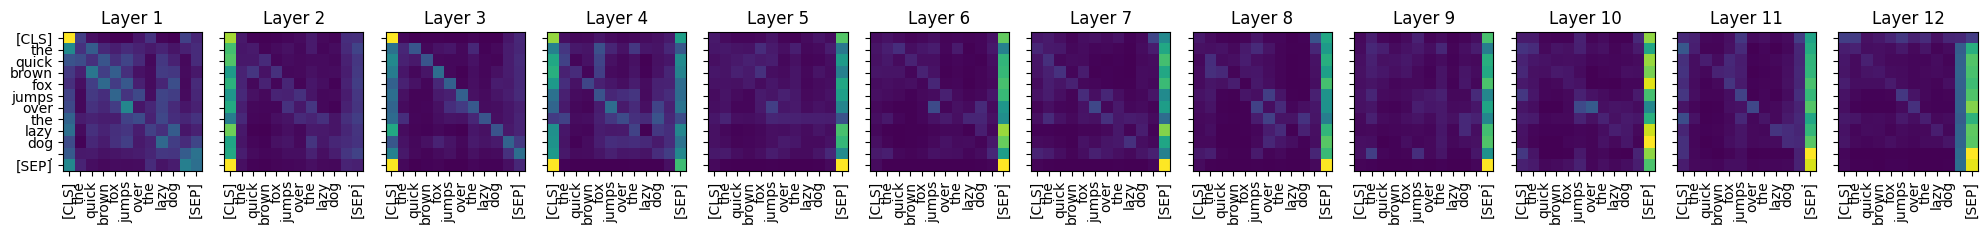

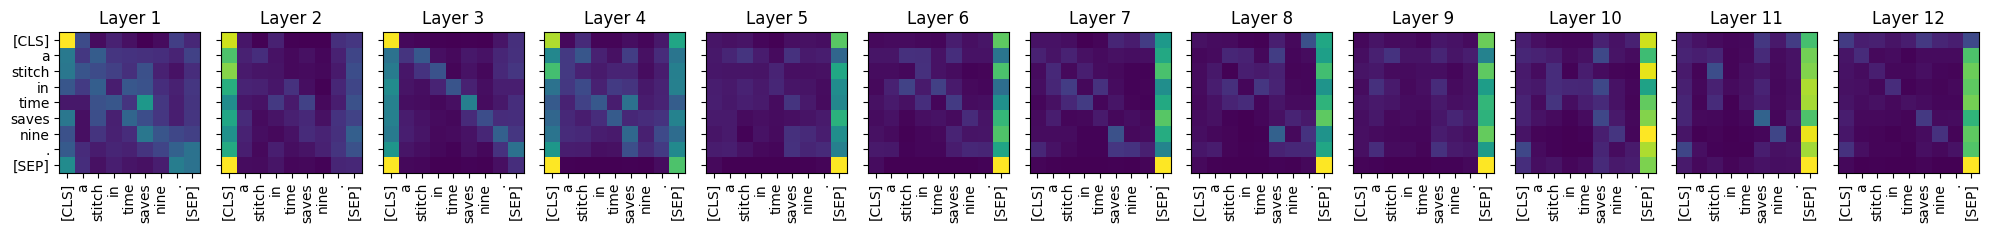

In [ ]:
import matplotlib.pyplot as plt

for i in range(2):
  fig, axs = plt.subplots(ncols=12, figsize=(20, 5))
  for layer, ax in enumerate(axs):
    # get attention weights of last transformer layer:
    aw = outputs['attentions'][layer][i].cpu()

    # average over heads:
    aw = aw.mean(dim=0)

    # remove padding tokens:
    mask = inputs['attention_mask'][i]
    aw = aw[mask == 1, :][:, mask == 1]

    # create labels:
    labels = tokenizer.convert_ids_to_tokens(inputs['input_ids'][i][mask == 1])
    x = np.arange(len(labels))

    ax.imshow(aw.detach().numpy())
    ax.set_xticks(ticks=x, labels=labels, rotation=90)
    ax.set_yticks(ticks=x, labels=['']*len(x))
    ax.set_title(f'Layer {layer+1}')

  axs[0].set_yticks(ticks=x, labels=labels)
  plt.tight_layout()
  plt.show()

Note how every attention layer focuses on different token combinations.

### Example: using pretrained models as embeddings without furter fine-tuning

Let's load a dataset:

From (https://paperswithcode.com/dataset/ag-news)[https://paperswithcode.com/dataset/ag-news]:
> *AG News (AG’s News Corpus) is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus. The AG News contains 30,000 training and 1,900 test samples per class.*

In [ ]:
from datasets import load_dataset

labels = ["World", "Sports", "Business", "Sci/Tech"]
data = load_dataset("ag_news", split='train[:2000]')
data

In [ ]:
data[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

Add a tokenization step to the pipeline:

In [ ]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length')

data = data.map(tokenize_function, batched=True)
data

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})

Hide irrelevant features:

In [ ]:
data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
data[0]

{'label': tensor(2),
 'input_ids': tensor([  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
          1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
          2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
          1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

Calculate BERT embeddings:

In [ ]:
x, y = [], []

# predict:
for batch in tqdm(DataLoader(data, batch_size=32)):
  with torch.no_grad():
    y.extend(batch.pop('label').cpu().numpy())

    batch = {k: v.to(device) for k, v in batch.items()}
    x.extend(model(**batch).pooler_output.cpu().numpy())

# convert lists to numpy:
x = np.array(x)
y = np.array(y)

x.shape, y.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:15<00:00,  4.05it/s]


((2000, 768), (2000,))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.91s/it]


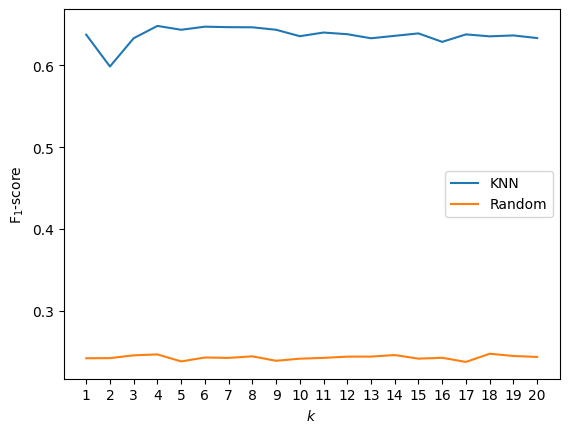

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

f1_knn, f1_rnd = [], []
ks = np.arange(1, 21)
for k in tqdm(ks):
  f1_knn.append([])
  f1_rnd.append([])

  # Monte-Carlo cross-validation with 50 splits:
  mc = ShuffleSplit(n_splits=50, test_size=0.25, train_size=None)
  for idx_train, idx_test in mc.split(x):

    # knn classifier:
    knn = KNeighborsClassifier(n_neighbors=k).fit(x[idx_train], y[idx_train])
    y_pred = knn.predict(x[idx_test])
    f1_knn[-1].append(f1_score(y[idx_test], y_pred, average='macro'))

    # random baseline:
    y_rnd = np.random.randint(0, len(labels), size=len(y[idx_test]))
    f1_rnd[-1].append(f1_score(y[idx_test], y_rnd, average='macro'))

# convert to numpy:
f1_knn = np.array(f1_knn)
f1_rnd = np.array(f1_rnd)

# plot:
plt.plot(np.mean(f1_knn, axis=1), label='KNN')
plt.plot(np.mean(f1_rnd, axis=1), label='Random')
plt.legend()
plt.xticks(ticks=ks-1, labels=ks)
plt.xlabel('$k$')
plt.ylabel('F$_1$-score')
plt.show()

In [ ]:
from typing import Iterable
from transformers import BertModel, BertTokenizer
from numpy.typing import NDArray
from sklearn.metrics.pairwise import cosine_similarity

---

<span style="color:red"><b>TASK 1</b> - Text similarity:</span>

---

Write a function to compute text similarity using cosine similarity between BERT embeddings of different texts. The function should take a list of $n$ strings as its input and return a similarity matrix $\in \mathbb{R}^{n \times n}$.

Afterward, use this function to compute the similarity for the sentences in `data.zip/task1/sentences.csv` and upload your solution to NextIlearn.

**Hint:** See [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) for documentation of the `sklearn.metrics.pairwise.cosine_similarity` function.

In [3]:
from typing import Iterable
from transformers import BertModel, BertTokenizer
from numpy.typing import NDArray
from sklearn.metrics.pairwise import cosine_similarity

def text_similarity(texts: Iterable[str], model: BertModel, tokenizer: BertTokenizer, device: torch.device) -> np.ndarray:
    model.eval()

    embeddings = []

    batch_size = 32
    data_loader = DataLoader(texts, batch_size=batch_size)

    for batch in tqdm(data_loader):
        encodings = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in encodings.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        sentence_embeddings = outputs.pooler_output.cpu().numpy()
        embeddings.extend(sentence_embeddings)

    embeddings = np.array(embeddings)

    similarity_matrix = cosine_similarity(embeddings)

    return similarity_matrix

In [ ]:
# calculate similarity for sample sentences:
sentences  = pd.read_csv('data/task1/sentences.csv', index_col=0)
similarity = text_similarity(sentences['sentences'].values.tolist(), model, tokenizer, device)
pd.DataFrame(similarity).to_csv('similarity.csv')

100%|██████████| 7/7 [00:00<00:00, 31.16it/s]


---

*End of Task 1. Upload your final predictions (the file* `similarity.csv` *) to* **Homework 2 - Code** *on* **NextIlearn**

When you are done with Task 1, feel free to play around with the function a little:

100%|██████████| 1/1 [00:00<00:00, 74.91it/s]


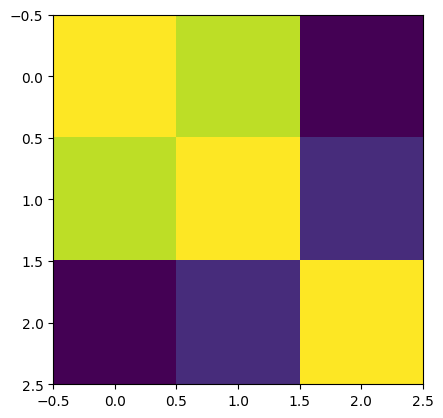

In [ ]:
plt.imshow(text_similarity(['Paul is cooking dinner for his friend.', 'Maria is cooking dinner for her friend.', 'Stockholm is a beautiful city!'], model, tokenizer, device))

## 2. Fine-tuning BERT for Text Classification

While the KNN classifier based on BERT embeddings is already performing well, we can improve on them by fine-tuning the model for our task. We will reuse the data preprocessing pipeline we used before!

In [ ]:
# split data in training and test set:
split_data = data.train_test_split(test_size=0.25)
split_data

In [ ]:
# create dataloaders:
train_dataloader = DataLoader(split_data['train'], batch_size=8)
test_dataloader = DataLoader(split_data['test'], batch_size=8)

For classification, we need a different "head" on our model. Huggingface provides different setups for each model (see [huggingface documentation](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html)):

*   `transformers.AutoModel`
*   `transformers.AutoModelForPreTraining`
*   `transformers.AutoModelWithLMHead`
*   `transformers.AutoModelForSequenceClassification`
*   `transformers.AutoModelForQuestionAnswering`
*   `transformers.AutoModelForTokenClassification`

For text classification we use `transformers.AutoModelForSequenceClassification`:

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model = model.to(device)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

As you can see, this model has an **additional linear layer** after the pooler layer. It also comes with built-in loss calculation for convenience:

```Python
loss = None
if labels is not None:
    if self.config.problem_type is None:
        if self.num_labels == 1:
            self.config.problem_type = "regression"
        elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
            self.config.problem_type = "single_label_classification"
        else:
            self.config.problem_type = "multi_label_classification"

    if self.config.problem_type == "regression":
        loss_fct = MSELoss()
        if self.num_labels == 1:
            loss = loss_fct(logits.squeeze(), labels.squeeze())
        else:
            loss = loss_fct(logits, labels)
    elif self.config.problem_type == "single_label_classification":
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    elif self.config.problem_type == "multi_label_classification":
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
```
(*from* [https://github.com/huggingface/transformers/blob/v4.51.3/src/transformers/models/bert/modeling_bert.py](https://github.com/huggingface/transformers/blob/v4.51.3/src/transformers/models/bert/modeling_bert.py#L1692))


Let's try this out:

In [ ]:
model(
  input_ids      = data[:1]['input_ids'].to(device),
  attention_mask = data[:1]['attention_mask'].to(device),
  labels         = data[:1]['label'].to(device)
)

SequenceClassifierOutput(loss=tensor(1.3857, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-0.5731, -0.1855, -0.2361, -0.0277]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Now let's train this model. Remember, that **in fine-tuning we want to update the pretrained weights, not re-train the model**. Therefore, we train the model for a low number of epochs with a low learning rate. The original BERT paper proposes the following configuration ([Devlin et al, 2019](https://doi.org/10.48550/arXiv.1810.04805)):

* **Learning rate with Adam:** *5e-5, 3e-5, 2e-5*
* **Number of epochs:** *2, 3, 4*

Further reading: *Huggingface also provides a* `transformers.Trainer`*-class that you may want to try out for convenience: [https://huggingface.co/docs/transformers/main_classes/trainer](https://huggingface.co/docs/transformers/main_classes/trainer)*

In [ ]:
from torch.optim import AdamW

# Optimizer:
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop:
loss_train = []
for epoch in range(2):

  model.train()
  loss_train.append([])
  for batch in train_dataloader:
    optimizer.zero_grad()

    outputs = model(
      input_ids      = batch['input_ids'].to(device),
      attention_mask = batch['attention_mask'].to(device),
      labels         = batch['label'].to(device)
    )

    loss = outputs.loss
    loss.backward()
    loss_train[-1].append(loss.item())

    optimizer.step()
  loss_train[-1] = np.mean(loss_train[-1])

  print(f"Epoch {epoch+1}: loss = {loss_train[-1]:.3f}")

Epoch 1: loss = 0.617
Epoch 2: loss = 0.249


In [ ]:
# Evaluation:
model.eval()
y_true, y_pred = [], []
for batch in test_dataloader:
  with torch.no_grad():
    outputs = model(
      input_ids      = batch['input_ids'].to(device),
      attention_mask = batch['attention_mask'].to(device)
    )

  y_pred.extend(outputs.logits.argmax(dim=1).cpu().numpy())
  y_true.extend(batch['label'].cpu().numpy())

f1_score(y_true, y_pred, average='macro')

0.9121445283085664

---

<span style="color:red"><b>TASK 2</b> - Fine-Tuning RoBERTa:</span>

---

Fine-tune [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta) a pretrained transformer model to classify the data you received along with this notebook (in `data.zip/task2/...`). **You are enouraged to use scheduling and early stopping, but remember to keep the learning rate low.**

**Upload the resulting predictions to NextIlearn. Your model should achieve an F$_1$ > .77 to pass.**

In [5]:
# Load labeled list of training files:
train_files = pd.read_csv('data/task2/train/labels.csv', index_col=0)
train_files['file'] = ['data/task2/train/' + s for s in train_files['file']]
print(f'# of positive samples: {(train_files.label == 1).sum():d}')
print(f'# of negative samples: {(train_files.label == 0).sum():d}')
train_files.head()

# of positive samples: 3640
# of negative samples: 8460


,file,label
0,data/task2/train/0000.txt,0
1,data/task2/train/0001.txt,0
2,data/task2/train/0002.txt,1
3,data/task2/train/0003.txt,0
4,data/task2/train/0004.txt,1


In [6]:
# Load training data sample:
with open(train_files.file.sample(1).iloc[0], 'r') as file:
    print(file.read())

@user What happened to wokeisis 


In [7]:
# Load list of test files:
import os
test_files = ['data/task2/test/' + s for s in os.listdir('data/task2/test/')]
test_files.sort()
test_files = pd.DataFrame({'file': test_files})
test_files.head()

,file
0,data/task2/test/0000.txt
1,data/task2/test/0001.txt
2,data/task2/test/0002.txt
3,data/task2/test/0003.txt
4,data/task2/test/0004.txt


In [21]:
from torch.utils.data import Dataset, random_split
from sklearn.metrics import f1_score
from torch.optim import AdamW, lr_scheduler
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Tokenizer:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Custom dataset class:
class TextDataset(Dataset):
    def __init__(self, file_paths, labels, tokenizer, max_length=128):
        self.file_paths = file_paths
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets:
train_dataset = TextDataset(train_files['file'].values, train_files['label'].values, tokenizer)

train_size = int(0.9 * len(train_dataset))  # 90% for training
val_size = len(train_dataset) - train_size  # 10% for validation
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Dataloaders:
train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_dataset = TextDataset(test_files['file'].values, np.zeros(len(test_files)), tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Model loading:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model = model.to(device)

# Optimizer and Scheduler:
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Early Stopping setup:
best_f1 = 0.0
patience = 3 
epochs_without_improvement = 0

# Training loop:
for epoch in range(10): 
    model.train()
    loss_train = []

    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()

        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['label'].to(device)
        )

        loss = outputs.loss
        loss.backward()
        loss_train.append(loss.item())

        optimizer.step()
        scheduler.step()

    avg_train_loss = np.mean(loss_train)
    print(f"Epoch {epoch+1}: Training loss = {avg_train_loss:.3f}")

    # Validation:
    model.eval()
    y_true, y_pred = [], []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )

        y_pred.extend(outputs.logits.argmax(dim=1).cpu().numpy())
        y_true.extend(batch['label'].cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Epoch {epoch+1}: Validation F1 score = {f1:.3f}")

    # Early Stopping Logic:
    if f1 > best_f1:
        best_f1 = f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_roberta_model.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping!")
            break

model.load_state_dict(torch.load("best_roberta_model.pth"))
model.eval()

# Predict on the test set:
y_pred = []
for batch in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device)
        )

    y_pred.extend(outputs.logits.argmax(dim=1).cpu().numpy())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 341/341 [01:13<00:00,  4.65it/s]


Epoch 1: Training loss = 0.472


100%|██████████| 38/38 [00:02<00:00, 13.98it/s]


Epoch 1: Validation F1 score = 0.717


100%|██████████| 341/341 [01:14<00:00,  4.61it/s]


Epoch 2: Training loss = 0.384


100%|██████████| 38/38 [00:02<00:00, 14.02it/s]


Epoch 2: Validation F1 score = 0.768


100%|██████████| 341/341 [01:14<00:00,  4.60it/s]


Epoch 3: Training loss = 0.309


100%|██████████| 38/38 [00:02<00:00, 14.03it/s]


Epoch 3: Validation F1 score = 0.776


100%|██████████| 341/341 [01:14<00:00,  4.60it/s]


Epoch 4: Training loss = 0.218


100%|██████████| 38/38 [00:02<00:00, 14.00it/s]


Epoch 4: Validation F1 score = 0.775


100%|██████████| 341/341 [01:14<00:00,  4.60it/s]


Epoch 5: Training loss = 0.140


100%|██████████| 38/38 [00:02<00:00, 14.00it/s]


Epoch 5: Validation F1 score = 0.766


100%|██████████| 341/341 [01:14<00:00,  4.60it/s]


Epoch 6: Training loss = 0.092


100%|██████████| 38/38 [00:02<00:00, 14.02it/s]
/tmp/ipykernel_1611304/1926025492.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bes

Epoch 6: Validation F1 score = 0.765
Early stopping!


  0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipykernel_1611304/1926025492.py:36: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'label': torch.tensor(label, dtype=torch.long)
100%|██████████| 63/63 [00:04<00:00, 14.03it/s]


In [22]:
pd.DataFrame(y_pred, columns=['predictions']).to_csv('submission.csv')

---

*End of Task 2. Upload your final predictions (the file* `submission.csv` *) to* **Homework 2 - Code** *on* **NextIlearn**

## 3. Simple Autoregressive Extension of BERT

BERT is not autoregressive by design. Here, we try to simulate next-token prediction using BERT with causal masking.

Remember, that in the MLM pretraining task, BERT is trained to predict the most probable token corresponding to the input token `'[MASK]'`.

E.g.: `'[CLS] The weather is [MASK]. [SEP]'` → **BERT** → `'[CLS] The weather is great. [SEP]'`

We will use this to simulate autoregression, i.e. the generation of a text token by token.

In [ ]:
from transformers import AutoModelForMaskedLM
model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')
model = model.to(device)
model.eval()
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

An example:

In [ ]:
sentence = "The capital of France is [MASK]."

# tokenize:
inputs = tokenizer(sentence, return_tensors="pt").to(device)

# generate:
with torch.no_grad():
    logits = model(**inputs).logits

logits.shape

torch.Size([1, 9, 30522])

The shape of `logits` is:

  *number of texts* $~\times~$ *number of tokens*  $~\times~$  *vocabulary size*

→ This is a collection of token probabilities!

In [ ]:
# get top prediction for masked token:
predicted_token_id = logits[0, -3].argmax(axis=-1)

print("Predicted token:", tokenizer.decode(predicted_token_id))


Predicted token: paris


Now let's make this a function:

In [ ]:
from typing import Optional
def complete_text(prompt:str, max_tokens:Optional[int]=None, model=model, tokenizer=tokenizer, device=device):
  # use the whole context window if max_tokens not specified:
  if max_tokens is None: max_tokens = tokenizer.model_max_length - len(tokenizer(prompt).input_ids)

  # pad prompt with '[MASK]' tokens to tell BERT the number of tokens:
  prompt += ' '.join(['[MASK]']*max_tokens)

  # tokenize:
  inputs = tokenizer(prompt, return_tensors="pt").to(device)

  # generate token probabilities:
  with torch.no_grad():
    logits = model(**inputs).logits

  # get top prediction for first masked token:
  predicted_token_id = logits[0, -max_tokens-1].argmax(axis=-1).cpu().tolist()

  text = tokenizer.decode(inputs.input_ids[0, 1:-max_tokens-1].cpu().tolist() + [predicted_token_id])

  # end autoregression if max_tokens == 1:
  if max_tokens == 1: return text

  # end autoregression on '.' token:
  if predicted_token_id == tokenizer.vocab['.']: return text

  # end autoregression on [SEP] token:
  if predicted_token_id == tokenizer.sep_token_id: return text

  return complete_text(text, max_tokens=max_tokens-1, model=model, tokenizer=tokenizer, device=device)

Let's see if it works:

In [ ]:
complete_text("The capital of France is ", max_tokens=2)

'the capital of france is paris.'

In [ ]:
complete_text("The capital of France is ", max_tokens=100)

'the capital of france is that, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city, that city.'

Another example:

In [ ]:
complete_text("one plus one is equal to ", max_tokens=2)

'one plus one is equal to one.'

In [ ]:
complete_text("one plus one is equal to ")

'one plus one is equal to be an old man.'